In [46]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

from src.utils.config import RESNET34_FULL,RESNET18_FULL,BEETLE_DATASET, Config
from src.models import download_model, load_model_weights_and_metrics, GenModel


In [50]:
model_config = RESNET34_FULL
model_18_config = RESNET18_FULL
dataset_config =BEETLE_DATASET

config = Config()

model = download_model(model_config, dataset_config)
_, _, _, _ = load_model_weights_and_metrics(model, model_config)

model_18 = download_model(model_18_config, dataset_config)
_, _, _, _ = load_model_weights_and_metrics(model_18, model_18_config)

gen = GenModel()

In [3]:
def gauss(x, mean, std):
    exp = (x- mean)**2 / (2*std**2)
    return torch.exp(-exp)
    

In [4]:
def gen_input(start, end, step_size, std=0.25):
    r = int(end-start)
    l = int(r/step_size) - int(1/step_size) + 1
    ret = torch.zeros((  l, r))
    for i in range(l):
        x = torch.linspace(start, end-1, r)
        ret[i] = gauss(x, start + step_size*i, std)

    return ret.reshape(ret.shape[0],ret.shape[1], 1,1)

In [23]:
def walk(X, gen, model, batch_size, device='cuda'):
    ret = np.zeros(X.shape[0])
    l = int(X.shape[0] // batch_size)


    m = torch.tensor(config.mean)
    s = torch.tensor(config.std)
    mean_tensor = torch.zeros(3,224,448)
    std_tensor = torch.zeros(3,224,448)
    mean_tensor[0,:] = m[0]   
    mean_tensor[1,:] = m[1] 
    mean_tensor[2,:] = m[2] 

    std_tensor[0,:] = s[0]   
    std_tensor[1,:] = s[1] 
    std_tensor[2,:] = s[2] 
    mean = mean_tensor.to(device)
    std = std_tensor.to(device)

    gen = gen.to(device)
    model = model.to(device)
    for i in range(l):
        if i % 100 == 0:
            print(f'{i} of {l}')
        batch = X[i*batch_size:(i+1)*batch_size]
        batch = batch.to(device)

        img = (gen(batch) - mean)/std
        res = model(img).cpu().detach().numpy()
        ret[i*batch_size:(i+1)*batch_size] = np.argmax(res, 1)

    return ret

# linear walk along "x" axis

Each vector that is generated as input is close to a binary vector.
A normal distribution is used as interpolation to create values between each axis in the vector

In [6]:
start = 0
end = 100
step_size = 0.1
batch_size=32

correction = int(1/step_size)-1

In [7]:
linwalk_x = gen_input(start,end,step_size)

In [51]:
linwalk = walk(linwalk_x, gen, model, batch_size)
linwalk_18 = walk(linwalk_x, gen, model_18, batch_size)

0 of 30
0 of 30


In [9]:
l = int((end-start)/step_size)

res_x = np.linspace(start,end-1, l-correction)

# 'x' walk for resnet34

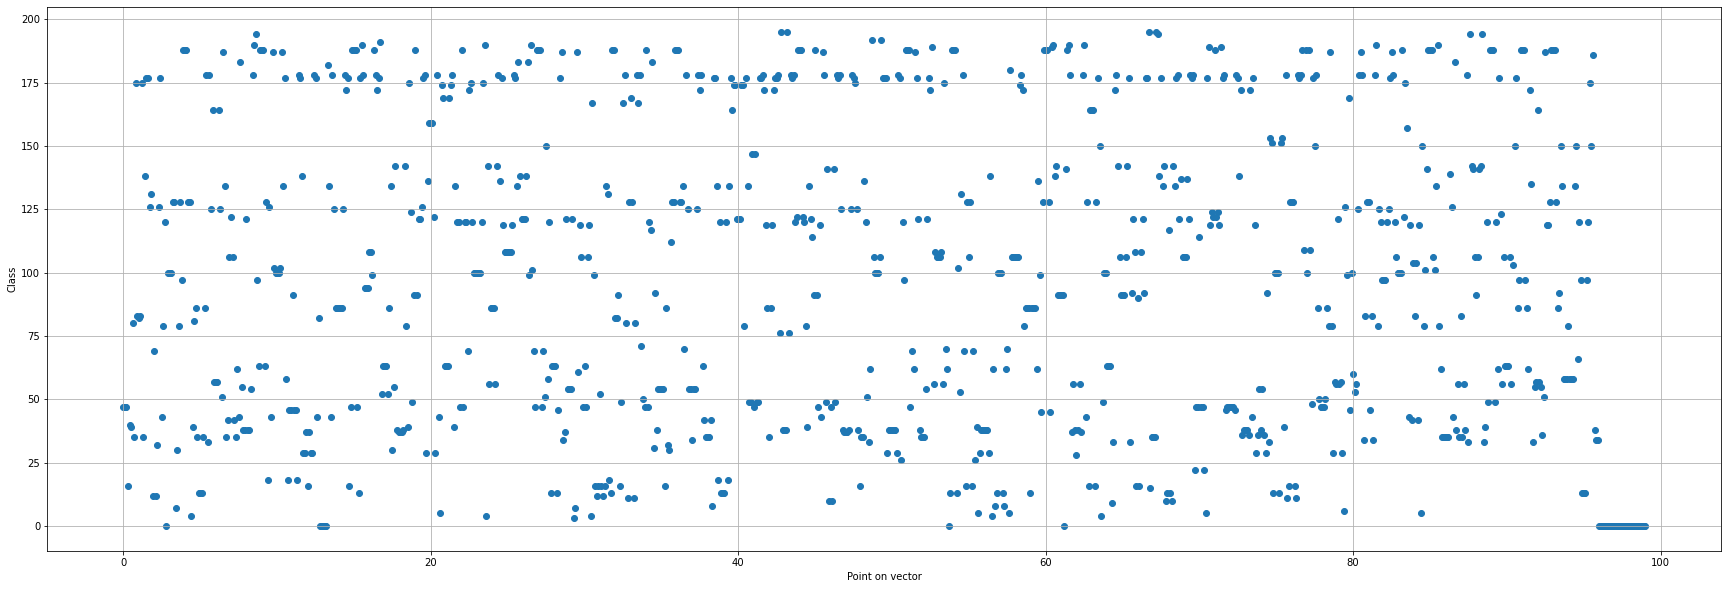

In [10]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

ax.scatter(res_x, linwalk)
ax.set_ylabel('Class')
ax.set_xlabel('Point on vector')
ax.grid()

This suggests that the generator can only generate a subset of beetle classes. 

The high end of this "spectrum" (95+) seems to all classify as class 0. This is very odd.

# compare walk of resnet34 and resnet 18

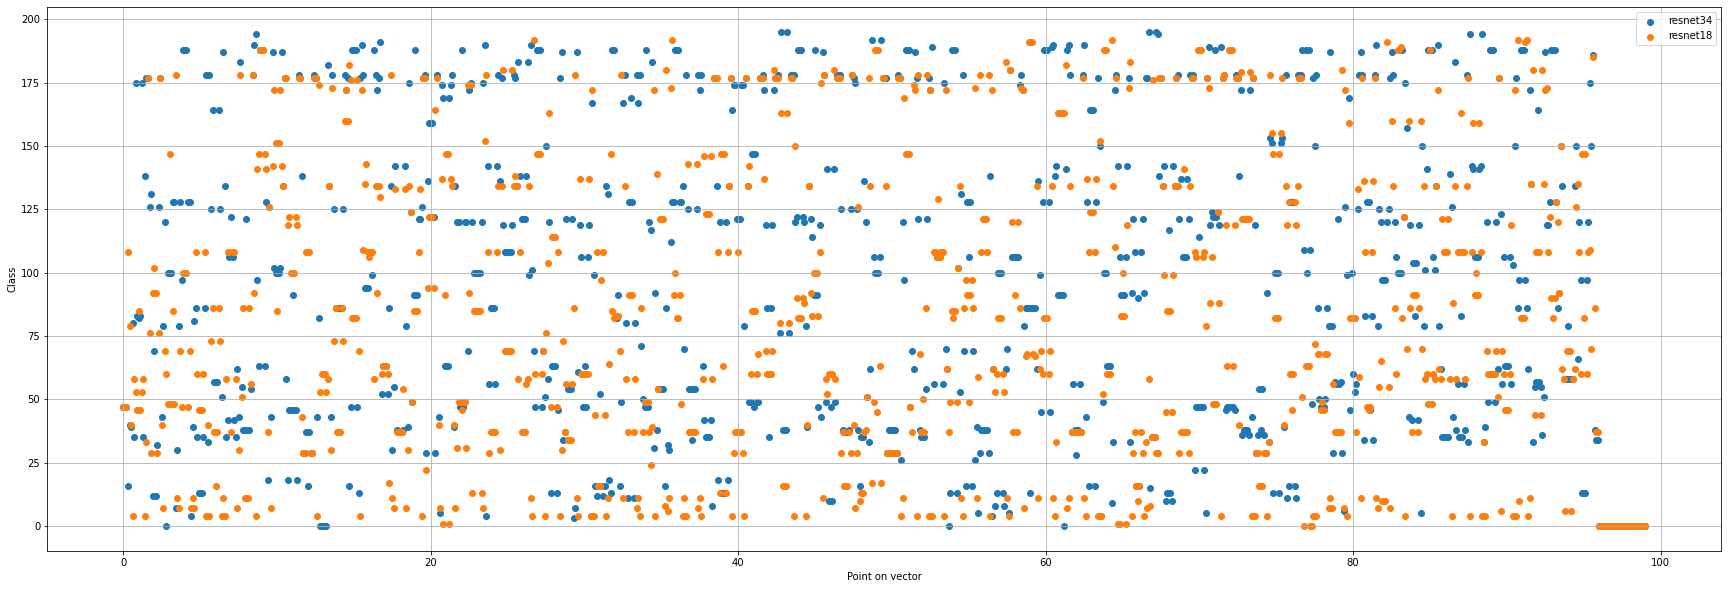

In [55]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

ax.scatter(res_x, linwalk, label='resnet34')
ax.scatter(res_x, linwalk_18, label='resnet18')
ax.set_ylabel('Class')
ax.set_xlabel('Point on vector')
ax.grid()
ax.legend()

The two models think the images should be classified differently

### Lets compare the number of each class that the models see

In [56]:
class_count_gen = np.bincount(linwalk.astype(np.int64), minlength=197)
class_count_gen_18 = np.bincount(linwalk_18.astype(np.int64), minlength=197)

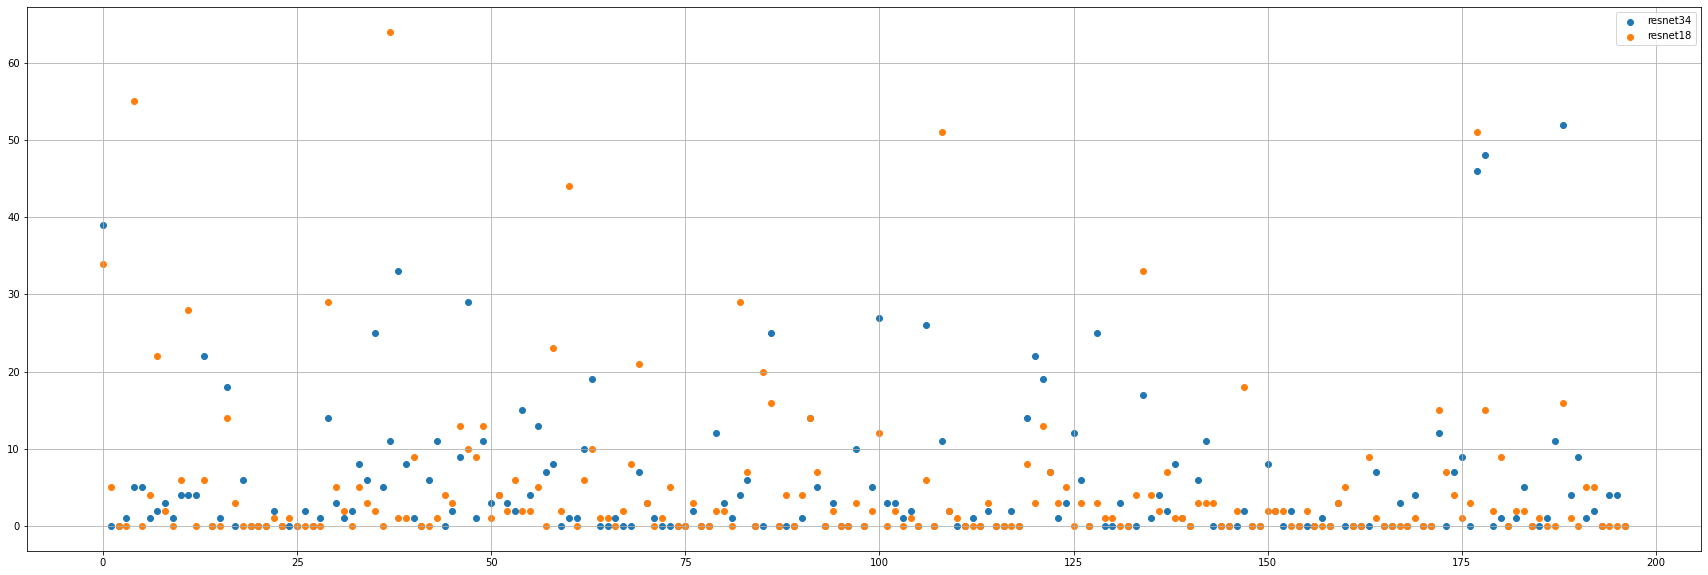

In [58]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

xs = np.linspace(0,196,197)

ax.scatter(xs, class_count_gen,label='resnet34')
ax.scatter(xs, class_count_gen_18,label='resnet18')
ax.grid()
ax.legend()

### Lets see if the distribution has something to do with the number of files for each class

In [12]:
path = './data/beetles/images/'

class_count_files = np.zeros(197)

folders = list(os.listdir(path))
folders.sort()

for i in range(len(folders)):
    class_count_files[i] = len(os.listdir(path+folders[i]))


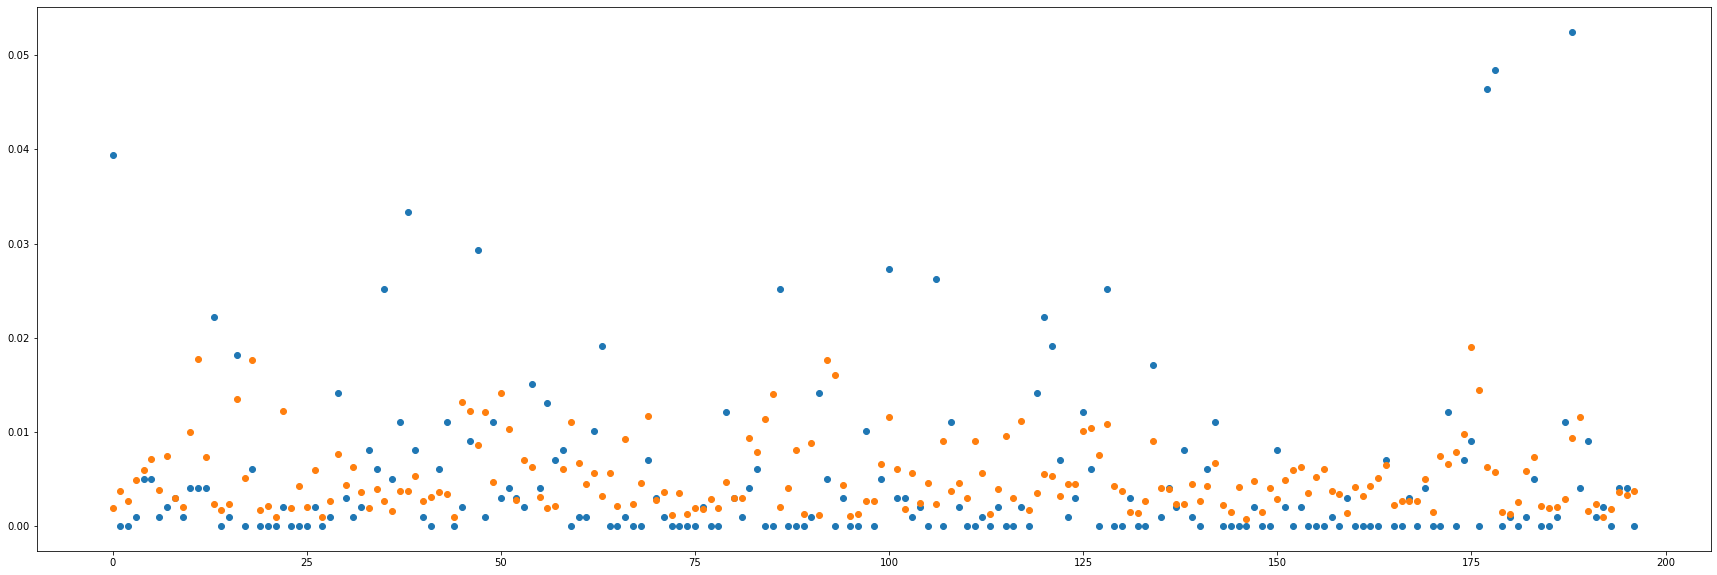

In [13]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

xs = np.linspace(0,196,197)

ax.scatter(xs, class_count_gen/np.sum(class_count_gen))
ax.scatter(xs, class_count_files/np.sum(class_count_files))

It does not look like it is overrepresentation. 

# Lets try walking along each axis

In [14]:
def gen_input2(r):
    ret = torch.zeros((  100*100, 100))
    space = torch.linspace(-r,r, 100)
    for i in range(100):
        for j in range(100):
            temp = torch.zeros(100)
            temp[i] = space[j]
            ret[i*100+j] = temp

    return ret.reshape(ret.shape[0],ret.shape[1], 1,1)

In [15]:
mapwalk_x = gen_input2(1)

In [16]:
mapwalk = walk(mapwalk_x, gen, model, batch_size)

0 of 312
1 of 312
2 of 312
3 of 312
4 of 312
5 of 312
6 of 312
7 of 312
8 of 312
9 of 312
10 of 312
11 of 312
12 of 312
13 of 312
14 of 312
15 of 312
16 of 312
17 of 312
18 of 312
19 of 312
20 of 312
21 of 312
22 of 312
23 of 312
24 of 312
25 of 312
26 of 312
27 of 312
28 of 312
29 of 312
30 of 312
31 of 312
32 of 312
33 of 312
34 of 312
35 of 312
36 of 312
37 of 312
38 of 312
39 of 312
40 of 312
41 of 312
42 of 312
43 of 312
44 of 312
45 of 312
46 of 312
47 of 312
48 of 312
49 of 312
50 of 312
51 of 312
52 of 312
53 of 312
54 of 312
55 of 312
56 of 312
57 of 312
58 of 312
59 of 312
60 of 312
61 of 312
62 of 312
63 of 312
64 of 312
65 of 312
66 of 312
67 of 312
68 of 312
69 of 312
70 of 312
71 of 312
72 of 312
73 of 312
74 of 312
75 of 312
76 of 312
77 of 312
78 of 312
79 of 312
80 of 312
81 of 312
82 of 312
83 of 312
84 of 312
85 of 312
86 of 312
87 of 312
88 of 312
89 of 312
90 of 312
91 of 312
92 of 312
93 of 312
94 of 312
95 of 312
96 of 312
97 of 312
98 of 312
99 of 312
100 of 312

In [17]:
map_img = mapwalk.reshape(100,100)

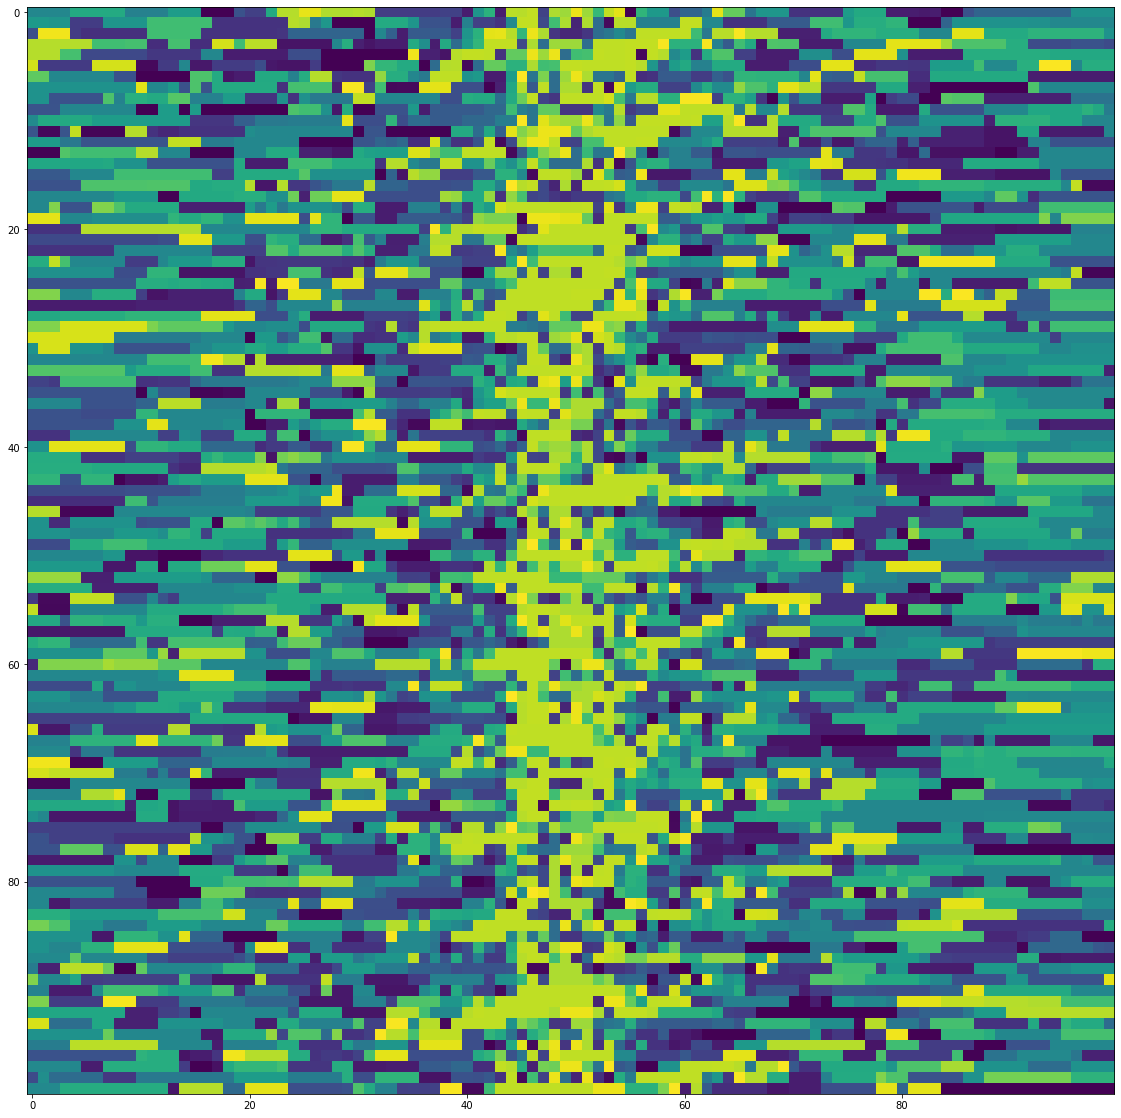

In [18]:
fig,ax = plt.subplots(1,1,figsize=(20,20))

ax.imshow(map_img)

Not sure what to make of this

In [19]:
map_classes = np.bincount(map_img.reshape(-1).astype(np.int64))

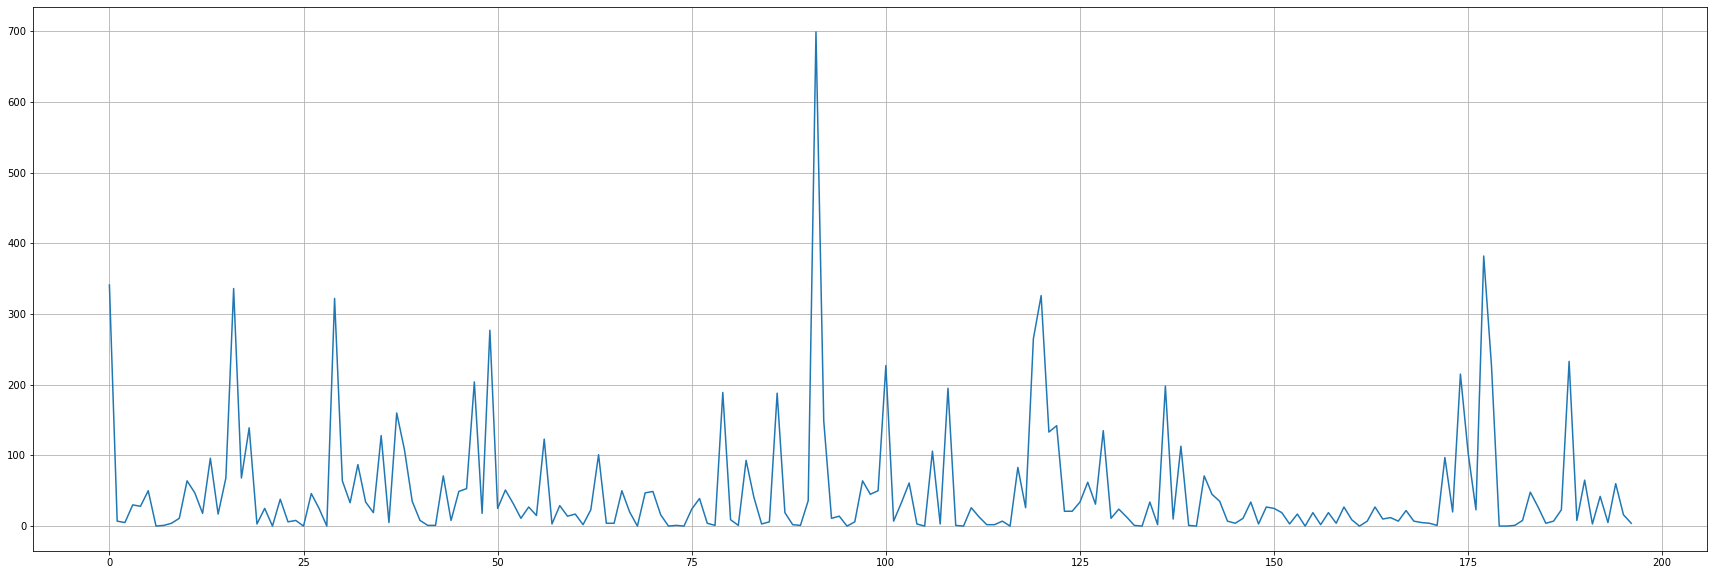

In [25]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

ax.plot(map_classes)
ax.grid()

# Random walk


lets generate a random input and count the classes to see how they are represented in the generator

In [21]:
randwalk_x = torch.normal(0,1,(100000,100,1,1))

In [24]:
randwalk = walk(randwalk_x, gen, model, batch_size)

0 of 3125
100 of 3125
200 of 3125
300 of 3125
400 of 3125
500 of 3125
600 of 3125
700 of 3125
800 of 3125
900 of 3125
1000 of 3125
1100 of 3125
1200 of 3125
1300 of 3125
1400 of 3125
1500 of 3125
1600 of 3125
1700 of 3125
1800 of 3125
1900 of 3125
2000 of 3125
2100 of 3125
2200 of 3125
2300 of 3125
2400 of 3125
2500 of 3125
2600 of 3125
2700 of 3125
2800 of 3125
2900 of 3125
3000 of 3125
3100 of 3125


In [26]:
rand_classes = np.bincount(randwalk.astype(np.int64))

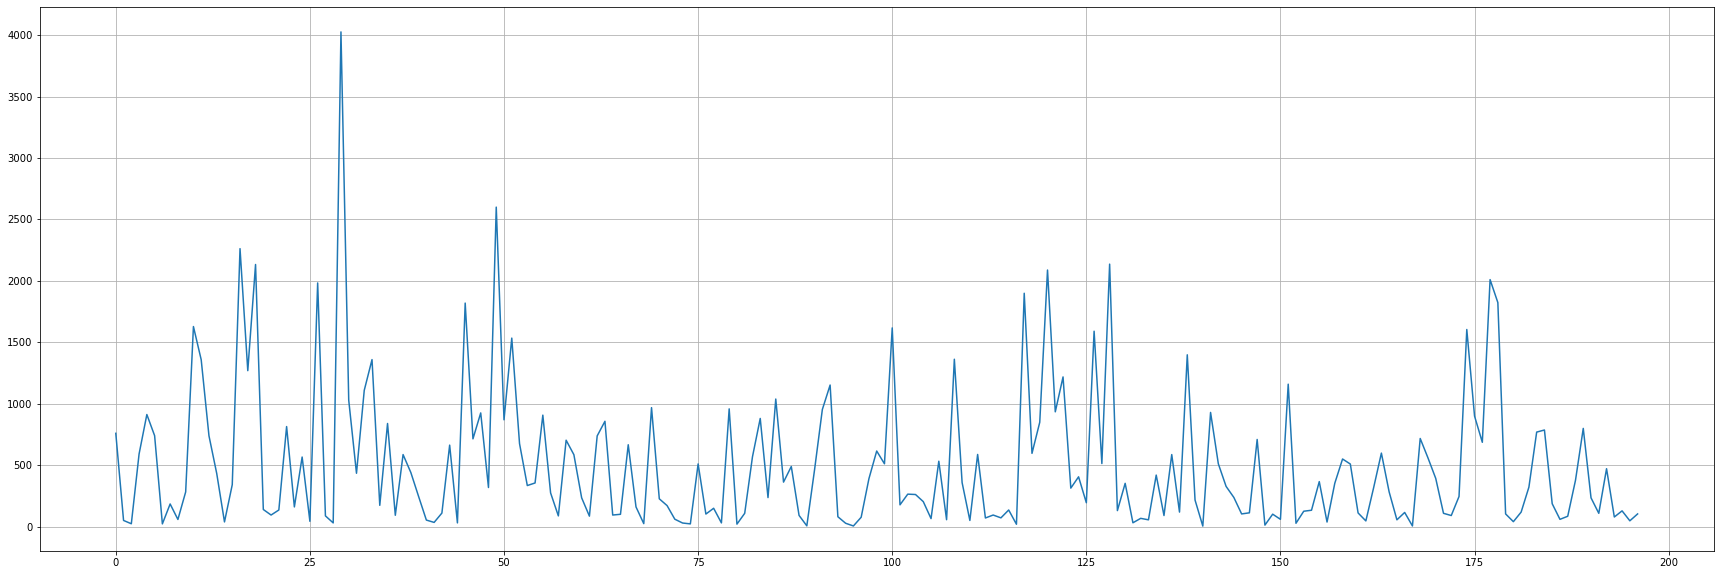

In [27]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')

ax.plot(rand_classes)
ax.grid()

In [29]:
import pandas as pd

In [45]:
class_nr = np.arange(197)

rand_data = np.vstack((class_nr.reshape(1,-1), rand_classes.reshape(1,-1)))
rand_df = pd.DataFrame(rand_data, index=['class', 'count'])
pd.set_option('display.max_columns', None)
rand_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196
class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196
count,759,50,23,591,912,740,22,184,58,282,1628,1358,739,432,38,341,2262,1269,2133,139,94,135,814,160,566,43,1983,87,30,4026,1029,434,1109,1359,173,839,92,586,440,245,53,34,110,663,30,1819,714,925,318,2600,869,1534,675,334,355,907,274,87,703,585,234,85,738,857,94,100,666,160,24,968,226,171,60,29,22,510,102,149,30,958,20,108,568,880,236,1038,362,489,91,6,464,953,1152,80,27,5,76,390,615,511,1617,177,264,261,203,65,532,56,1362,358,50,587,70,94,71,135,19,1899,596,849,2088,934,1218,313,405,194,1590,513,2136,130,352,31,67,55,419,90,586,118,1398,216,4,929,511,327,237,103,112,709,12,101,59,1159,27,125,133,366,37,353,550,509,111,46,316,598,282,55,115,5,717,559,392,108,90,245,1604,899,686,2010,1823,103,40,118,321,769,786,186,59,84,377,799,234,108,471,78,128,47,103
